In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

Number Of Players    :  15
Number Of Total Images Present    :  576


Distribution Per Player


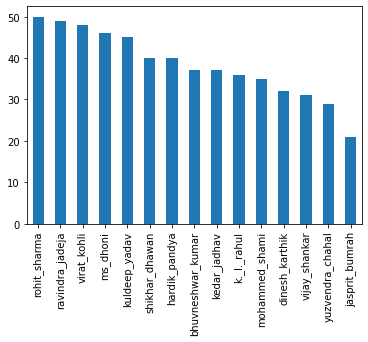

In [6]:
data = pd.read_csv("C:/Users/ansug/OneDrive/Desktop/Internship_pending_task_21may/players.csv")
data = data.sample(frac=1).reset_index(drop=True)

lab = preprocessing.LabelEncoder()
lab.fit(data['player'])
data['player_trans'] = lab.transform(data['player'])

n = int(len(data))
players = data.player.nunique()
print("Number Of Players    : ",players)
print("Number Of Total Images Present    : ",n)
print("\n\nDistribution Per Player")
data['player'].value_counts().plot.bar()

data = data[:-6]
test_data = data[-6:]

Distribution Per Player


<AxesSubplot:>

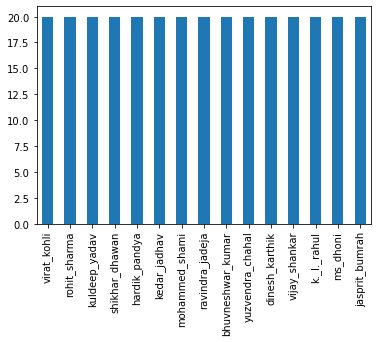

In [7]:
for index,row in data.iterrows():
    if len(data[data['player']==row['player']])>20:
        data.drop(data[data['image']==row['image']].index , inplace=True)

print("Distribution Per Player")
data['player'].value_counts().plot.bar()

In [10]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:image = tf.image.transpose(image)
    if p_rotate > .75:image = tf.image.rot90(image, k=3) 
    elif p_rotate > .5:image = tf.image.rot90(image, k=2) 
    elif p_rotate > .25:image = tf.image.rot90(image, k=1) 

    if p_pixel_1 >= .4:image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:image = tf.image.random_brightness(image, max_delta=.1)

    if p_crop > .7:
        if p_crop > .9:image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:image = tf.image.central_crop(image, central_fraction=.8)
        else:image = tf.image.central_crop(image, central_fraction=.9)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(224*.8),224, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    
    image = tf.image.resize(image, [224,224])
    return image,label

def load_img(image,player,player_transf):
    path = "C:/Users/ansug/OneDrive/Desktop/Internship_pending_task_21may/images/"+player+"/"+image
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img,player_transf
dataset = tf.data.Dataset.from_tensor_slices((data.image.values,data.player.values,data.player_trans.values))

In [11]:
train_ds = dataset.take(int(0.8*n))
val_ds = dataset.skip(int(0.8*n))
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(load_img,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.repeat(40).map(data_augment,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(32).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(load_img,num_parallel_calls=AUTOTUNE).batch(32).prefetch(buffer_size=AUTOTUNE)

In [12]:
b_model = keras.applications.MobileNetV2(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(b_model.output)
output = keras.layers.Dense(players, activation="softmax")(avg)
model = keras.Model(inputs=b_model.input, outputs=output)

for layer in b_model.layers:
    layer.trainable = False

In [13]:
checkpoint_path = "./checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
history = model.fit(train_ds, epochs=20, validation_data=val_ds,verbose=1,callbacks=[cp_callback])

Epoch 1/20
375/375 [==============================] - 577s 2s/step - loss: 1.5462 - accuracy: 0.5587

Epoch 00001: saving model to ./checkpoints\cp.ckpt
Epoch 2/20
375/375 [==============================] - 561s 1s/step - loss: 0.6734 - accuracy: 0.8569

Epoch 00002: saving model to ./checkpoints\cp.ckpt
Epoch 3/20
375/375 [==============================] - 312s 831ms/step - loss: 0.4329 - accuracy: 0.9193

Epoch 00003: saving model to ./checkpoints\cp.ckpt
Epoch 4/20
375/375 [==============================] - 245s 653ms/step - loss: 0.3149 - accuracy: 0.9467

Epoch 00004: saving model to ./checkpoints\cp.ckpt
Epoch 5/20
375/375 [==============================] - 247s 658ms/step - loss: 0.2350 - accuracy: 0.9643

Epoch 00005: saving model to ./checkpoints\cp.ckpt
Epoch 6/20
375/375 [==============================] - 239s 638ms/step - loss: 0.1949 - accuracy: 0.9725

Epoch 00006: saving model to ./checkpoints\cp.ckpt
Epoch 7/20
375/375 [==============================] - 243s 648ms/step 

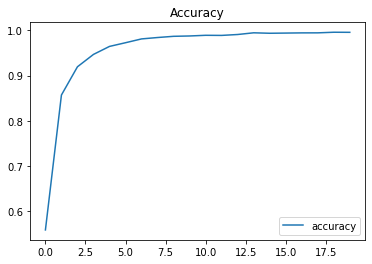

In [15]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history)[['accuracy']].plot()
plt.title("Accuracy")
plt.show()

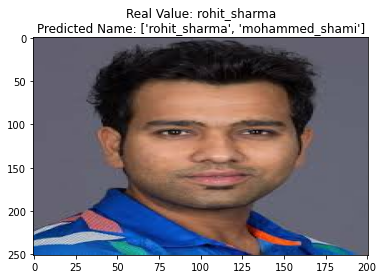

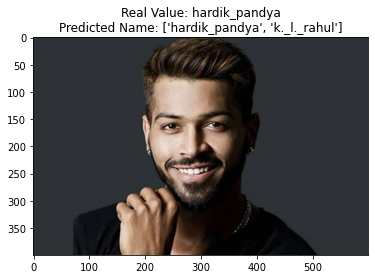

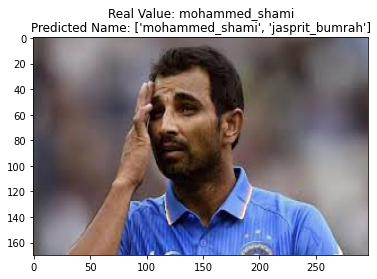

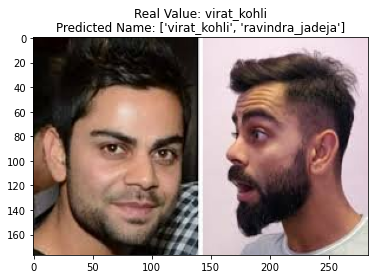

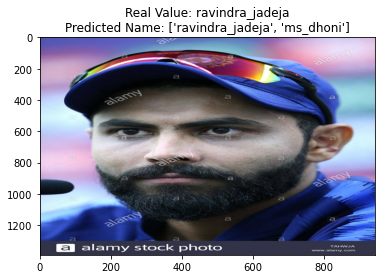

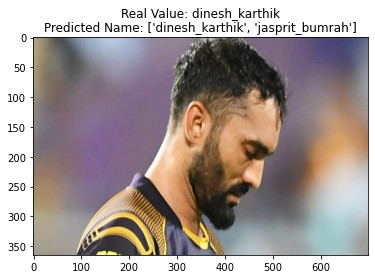

In [21]:
i=0
def load_test_img(image,player,player_transf):
    path = "C:/Users/ansug/OneDrive/Desktop/Internship_pending_task_21may/images/"+player+"/"+image
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img
test_ds = tf.data.Dataset.from_tensor_slices((test_data.image.values,test_data.player.values,test_data.player_trans.values))
test_ds = test_ds.map(load_test_img).batch(6)
prediction = model.predict(test_ds)

for index,row in test_data.iterrows():
    img = tf.io.decode_jpeg(tf.io.read_file("C:/Users/ansug/OneDrive/Desktop/Internship_pending_task_21may/images/"+row['player']+"/"+row['image']),channels=3)
    imgplot = plt.imshow(img.numpy().astype("uint8"),aspect='auto')
    real = str(list(lab.classes_)[row['player_trans']])
    top_k_values, top_k_indices = tf.nn.top_k(prediction[i], k=3)
    top_k_names = []
    for k in range(2):
        top_k_names+=[str(list(lab.classes_)[top_k_indices[k]])]
    plt.title("Real Value: "+str(real)+"\nPredicted Name: "+str(top_k_names))
    plt.show()
    i+=1

In [23]:
model.save("Evolv_ML.h5")

C:\Users\ansug\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
load_model = keras.models.load_model("Evolv_ML.h5")

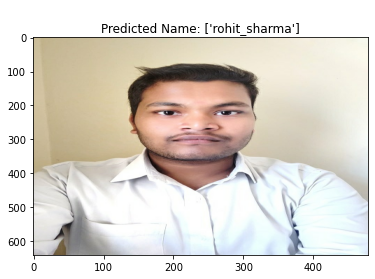

In [33]:
i=0
def load_test_img(image,player,player_transf):
    path = "C:/Users/ansug/OneDrive/Desktop/Internship_pending_task_21may/images/"+player+"/"+image
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img
test_ds = tf.data.Dataset.from_tensor_slices((test_data.image.values,test_data.player.values,test_data.player_trans.values))
test_ds = test_ds.map(load_test_img).batch(6)
prediction = load_model.predict(test_ds)

#for index,row in test_data.iterrows():
img = tf.io.decode_jpeg(tf.io.read_file("C:/Users/ansug/OneDrive/Desktop/Internship_pending_task_21may/Anshu/ME.jpg"),channels=3)
imgplot = plt.imshow(img.numpy().astype("uint8"),aspect='auto')
real = str(list(lab.classes_)[row['player_trans']])
top_k_values, top_k_indices = tf.nn.top_k(prediction[i], k=3)
top_k_names = []
for k in range(1):
    top_k_names+=[str(list(lab.classes_)[top_k_indices[k]])]
plt.title("\nPredicted Name: "+str(top_k_names))
plt.show()
i+=1